# QFT

In [1]:
# Importing standard Qiskit libraries
from qiskit import *
from qiskit.circuit.library import U1Gate, UnitaryGate
from qiskit.visualization import *
from qiskit_aer import *
import qiskit.quantum_info as qi


import numpy as np
from math import pi,log2,sqrt

# For sparse matrices
from scipy import linalg
from scipy.sparse import *

#For continued fractions
from fractions import Fraction  


# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Choosing local simulation to run circuits
service = QiskitRuntimeService(channel="local")

## Phase rotation
We will need the phase rotation to implement the conditional B gate.

If our QFT has size $Q$, we are going to need the conditional phase rotation of angle $\omega$, the $Q$-th root of unity, $\omega=e^{i\frac{2\pi}{Q}}$. Also, the phase rotations of the succesive squaring of that angle.

In our gate ```R(phi)``` is the  **controlled** phase rotation for $e^{i\phi}$. Hence, we would implement the phase rotation of $\omega$ by ```R(2*pi/Q)```.

To use ```R``` we need to specify the control qubit and the target qubit, like in ```circuit.append(R(alpha),[control,target])```

In [2]:
def R(phi):
    return U1Gate(phi).control(1)

## Recursive construction of QFT

Now, write a function that recursively constructs the QFT circuit of size $Q=2^q$.

Remember that QISKIT is little-endian and our class notes are big-endian, so you will need to invert the order from class notes diagrams.

In [3]:
def QFT(Q):
    q = int(log2(Q))
    output = QuantumCircuit(q)
    if q == 1:
        output.h(0)
    else:
        for i in range(q-1):
            output.swap(i,i+1)
        output.append(QFT(Q/2),list(range(q-1)))
        omega = 2*pi/Q
        for i in range(q-1):
            output.append(R(omega),[q-1,i])
            omega = 2*omega
        output.h(q-1)
    return(output)

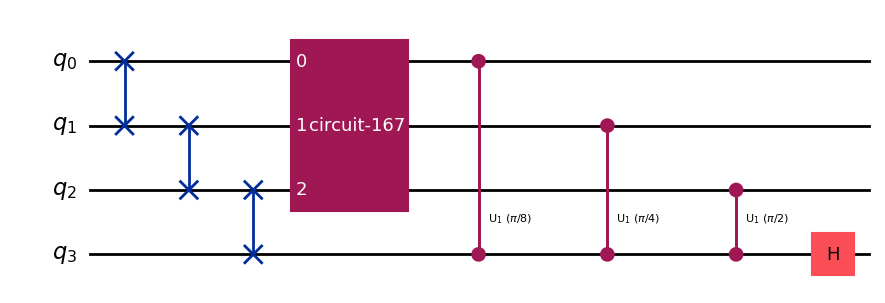

In [4]:
QFT(16).draw(output='mpl')

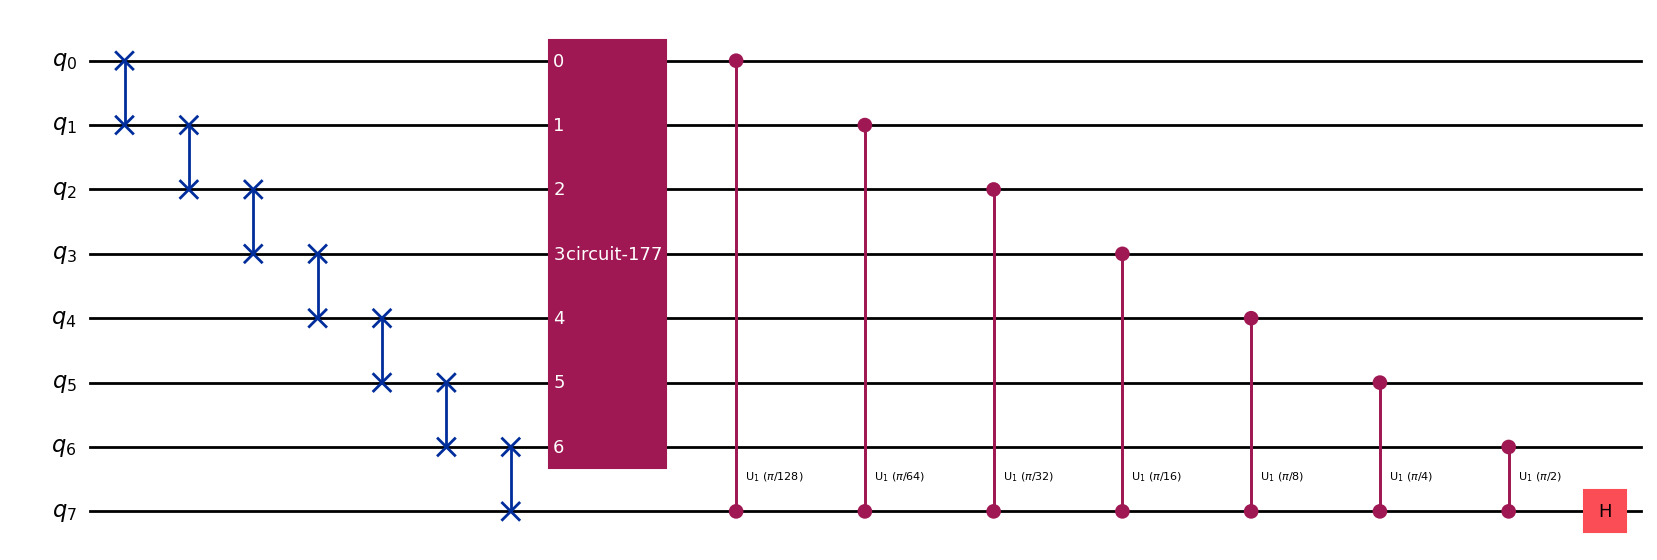

In [5]:
QFT(256).draw(output='mpl')

You can check if the right matrices are computed by checking the value of
```array_to_latex(sqrt(Q)*qi.Operator(QFT(Q)))``` for different values of $Q=2^q$.

In [6]:
array_to_latex(sqrt(2)*qi.Operator(QFT(2)))

<IPython.core.display.Latex object>

In [7]:
array_to_latex(2*qi.Operator(QFT(4)))

<IPython.core.display.Latex object>

In [8]:
array_to_latex(2*sqrt(2)*qi.Operator(QFT(8)))

<IPython.core.display.Latex object>

## Oracle and test
To check that QFT is working properly, let us compute the period of some modular power function.

Unfortunately, factoring even $15=3\cdot 5$ needs $Q=256$, and that in turn needs $q=8$ qubits for input of the oracle function (and $8$ qubits for output). The oracle would then be a $16$ qubit unitary, that is a $65536\times 65536$ matrix. This can make things very lengthy...

Instead, let us compute the Quantum Fourier Transform of the function $f(k)=3^k \mod 7$, so $N=7$. You can use the modular power function ```pow(3,k,7)``` and build the XOR oracle associated to it (in a similar way of what we did for Simon's algorithm oracle).

The size in the oracle in this case comes from $Q=64>49=7^2$, so that $q=6$.

In [9]:
def ket_reg(n,x):
    if x < 0 or x > 2**n-1:
        return(-1)
    output = [[0] for i in range(x)]+[[1]]+ [[0] for i in range(2**n-x-1)]
    return(np.int8(np.matrix(output)))

def bra_reg(n,x):
    return(np.int8(ket_reg(n,x).H))

def Shor_Oracle(a,N):
    q = int(2*np.log(N)/np.log(2))+1
    print("You will need "+str(q)+" qubits")
    unitary = np.zeros((4**q,4**q),dtype=np.int8)
    for i in range(2**q):
        for j in range(2**q):
           unitary += np.int8(np.kron(ket_reg(q,np.bitwise_xor(j, pow(a,i,N))),ket_reg(q,i)) @ np.kron(bra_reg(q,j),bra_reg(q,i)))
    return(UnitaryGate(unitary,label='U_F'))




In [10]:
i=1
j=2
a=2
N=3
q=2
np.int8(np.kron(ket_reg(q,np.bitwise_xor(j, pow(a,i,N))),ket_reg(q,i)) @ np.kron(bra_reg(q,j),bra_reg(q,i)))

matrix([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int8)

In [11]:
i=3
j=0
np.kron(bra_reg(q,j),bra_reg(q,i))

matrix([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int8)

In [39]:
def Sparse_Shor_Oracle(a,N):
    q = int(2*np.log(N)/np.log(2))+1
    print("You will need "+str(q)+" qubits")

    def XOR_fn(index,a,q):
        j = int(index/2**q)
        i = index-j*2**q
        col = coo_array(np.kron(ket_reg(q,np.bitwise_xor(j, pow(a,i,N))),ket_reg(q,i)))
        return(col.nonzero()[0][0])
    
    # Constructing a sparse array corresponding to the oracle
    col_iterable = (index for index in range(4**q))
    col = np.fromiter(col_iterable, np.int32)

    row_iterable = (XOR_fn(index,a,q) for index in range(4**q))
    row  = np.fromiter(row_iterable, np.int32)
    
    data = np.ones(4**q , dtype = np.int8)

    sparse_unitary = coo_array((data, (row, col)) , shape=(4**q, 4**q))
    unitary = np.zeros((4**q,4**q),dtype=np.int8)
    
    return sparse_unitary.toarray(out=unitary)
    #return(UnitaryGate(sparse_unitary.toarray(out=unitary),label='U_F',check_input=False))

In [40]:
Shor_Gate = Sparse_Shor_Oracle(3,7)

You will need 6 qubits


Use the ```Shor_Gate``` oracle to build a ```Shor``` circuit (you will need 12 qubits) that:
- Does a total superposition of the "input" qubits
- applies the oracle
- applies the QFT to the "input" qubits
- and measures them

In [47]:
def Shor_circuit(q,OracleMatrix):

    x = QuantumRegister(2*q,'x|y')
    out = ClassicalRegister(q,'output')
    Shor = QuantumCircuit(x,out)

    for i in range(q):
        Shor.h(i)

    Shor.barrier()

    Shor.unitary(OracleMatrix,x, label='Oracle')

    Shor.barrier()

    Shor.append(QFT(2**q),x[0:q])

    Shor.barrier()

    Shor.measure(x[0:q],out)

    return Shor

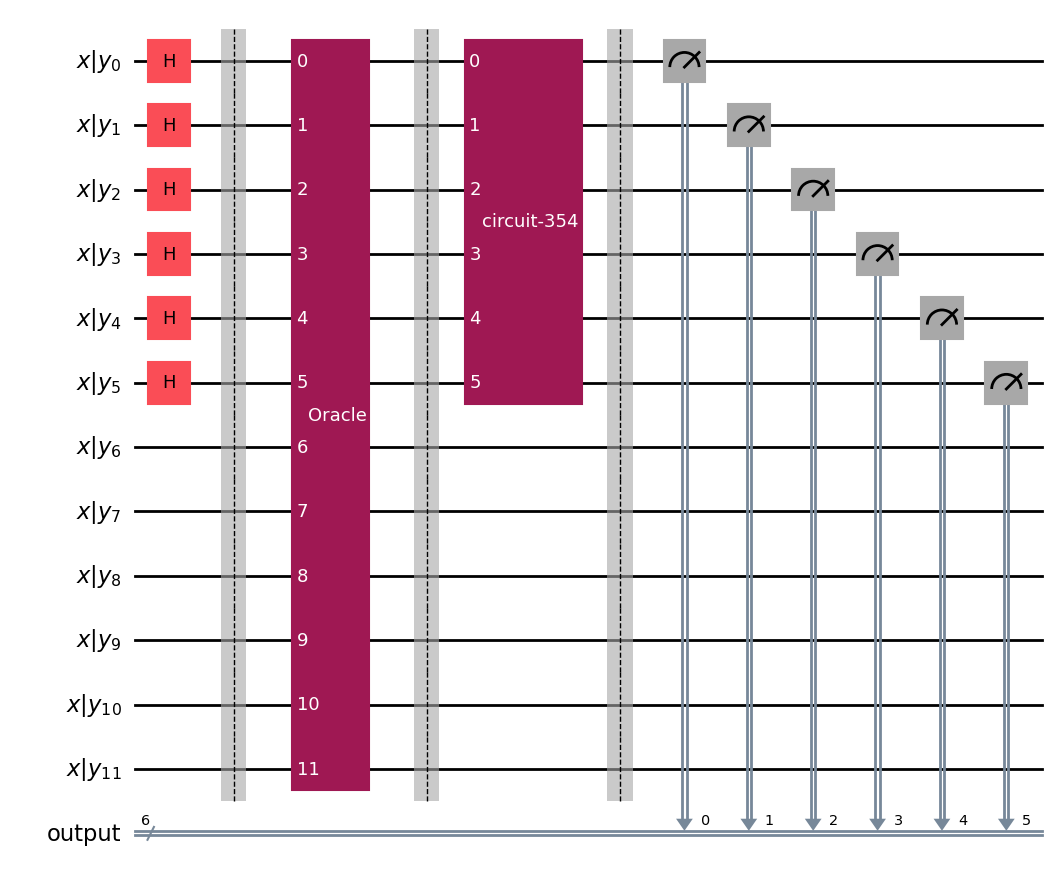

In [49]:
Shor6 = Shor_circuit(6,Shor_Gate)
Shor6.draw(output='mpl')

Let us get a histogram of the circuit. Can you compute the period of our modular power function?

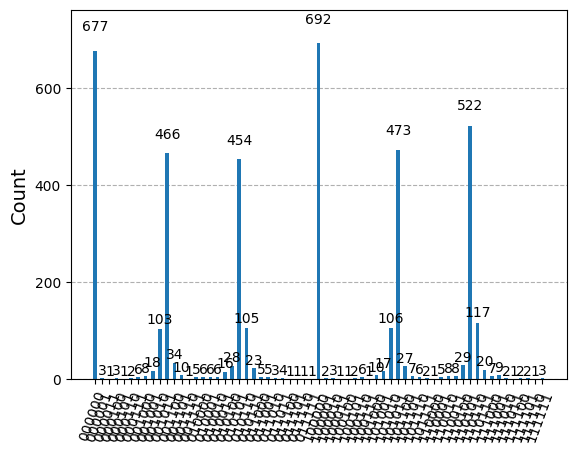

In [50]:
simulator = Aer.get_backend('aer_simulator')
circuit = transpile(Shor6, simulator)
result = simulator.run(circuit,shots=4096).result()
statistics = result.get_counts()
plot_histogram(statistics)

In [51]:
def best_denominator(measure,numqubits):
    return Fraction(measure/2**numqubits).limit_denominator(2**(numqubits/2)).denominator

In [53]:
simulator = Aer.get_backend('aer_simulator')
circuit = transpile(Shor6, simulator)
result = simulator.run(circuit,shots=10,memory=True).result()
for i in range(10):
    k = int(result.get_memory()[i],2)
    if k!=0:
        print(k,best_denominator(k,q))

53 6
44 3
22 3
32 2
21 3
32 2
10 6
42 3


Let us now factor 10 = 2* 5 (or 6 = 2 * 3)

In [54]:
Shor_Gate10 = Sparse_Shor_Oracle(3,10)

You will need 7 qubits


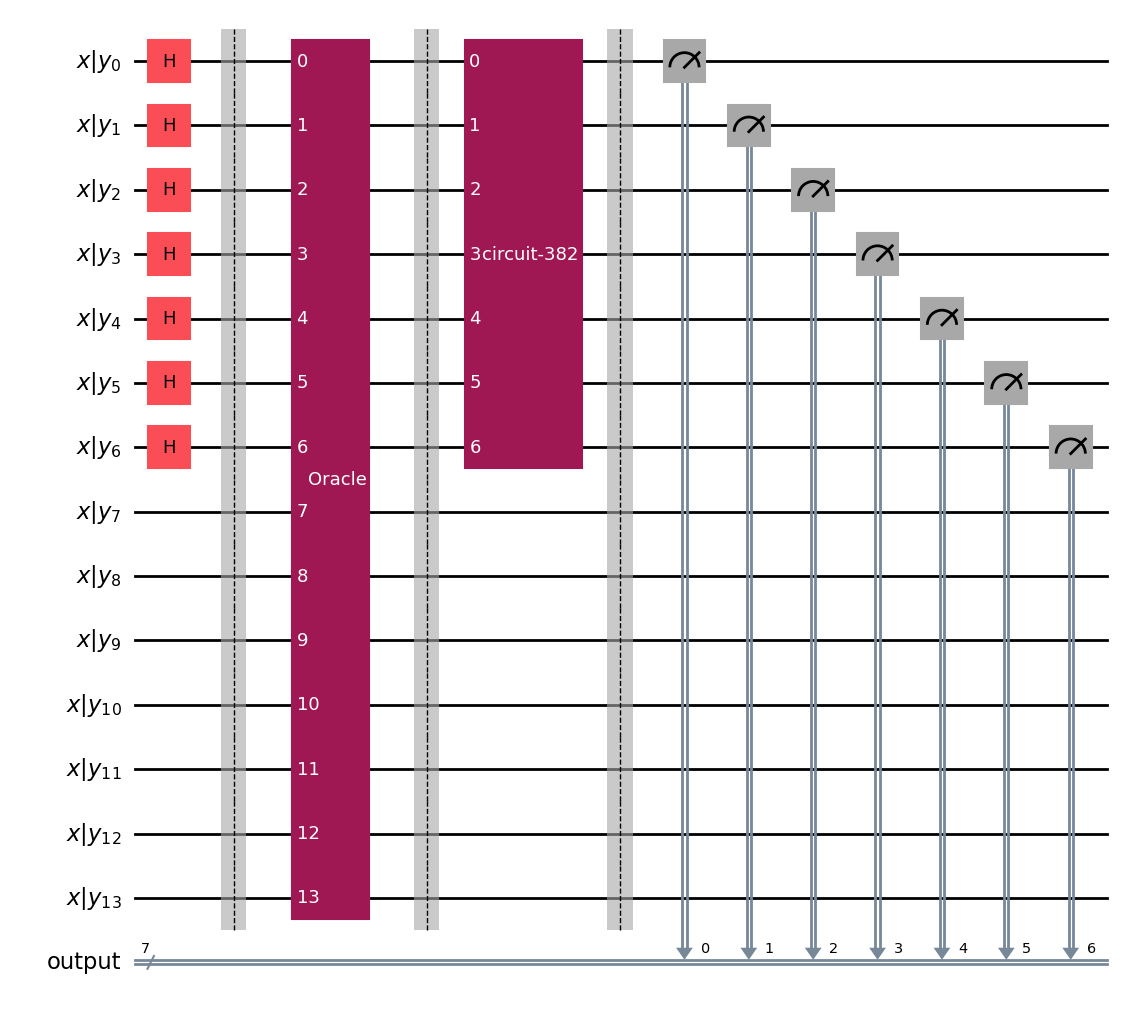

In [58]:
Shor7 = Shor_circuit(7,Shor_Gate10)
Shor7.draw(output='mpl')

In [60]:
simulator = Aer.get_backend('aer_simulator')
circuit = transpile(Shor7, simulator)
result = simulator.run(circuit,shots=10,memory=True).result()
for i in range(10):
    k = int(result.get_memory()[i],2)
    if k!=0:
        print(k,best_denominator(k,q))

32 2
32 2
64 1
96 2
64 1
32 2
96 2
32 2


In [61]:
Shor_Gate = Sparse_Shor_Oracle(4,15)

You will need 8 qubits
